### Generate proper structural connectome data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as pjoin

In [ ]:
# import the sc data
sc_dir = "/Users/yilewang/workspaces/data4project/lateralization/connectome/unzip"

# load caseid
table = pd.read_excel("/Users/yilewang/workspaces/data4project/mega_table.xlsx",sheet_name="tvb_parameters")
# get left and right sc weights
def get_sc_values(sc):
    # keep only the upper triangle
    upper = sc.where(np.triu(np.ones(sc.shape)).astype(bool))
    # turn NaN to 0
    upper = upper.fillna(0)
    
    upper_left = upper.iloc[:,::2]
    upper_right = upper.iloc[:,1::2]

    # only take even rows in upper_left
    upper_left = upper_left.iloc[::2,:]
    # only take odd rows in upper_right
    upper_right = upper_right.iloc[1::2,:]

    # flatten upper_left and get non-zero values from upper_left
    upper_left = upper_left.values.flatten()
    upper_left = upper_left[upper_left != 0]
    # flatten upper_right and get non-zero values from upper_right
    upper_right = upper_right.values.flatten()
    upper_right = upper_right[upper_right != 0]
    return upper_left, upper_right

# create an empty dataframe to store the sc values
sc_values = pd.DataFrame(columns=["group", "caseid"])

for group, caseid in zip(table["group"],table["caseid"]):
    sc = pd.read_csv(pjoin(sc_dir,group,caseid,"weights.txt"),sep="\s+",header=None)
    upper_left, upper_right = get_sc_values(sc)

    sc_values = pd.concat([sc_values, pd.DataFrame({"group":[group],"caseid":[caseid],"upper_left":[np.mean(upper_left)],"upper_right":[np.mean(upper_right)]})])
#     for i,j in zip(range(len(upper_left)), range(len(upper_right))):
#        # append the sc values to the dataframe, with group and caseid as first two columns
#        sc_values = pd.concat([sc_values, pd.DataFrame({"group":[group],"caseid":[caseid],"upper_left":upper_left[i],"upper_right":[upper_right[j]]})])
# print(sc_values)


In [ ]:
labels = ["Left Tracts"]*77 + ["Right Tracts"]*77
caseids = list(sc_values["caseid"]) + list(sc_values["caseid"])
# concate upper_left and upper_right
values = np.concatenate((sc_values["upper_left"],sc_values["upper_right"]))
groups = np.concatenate((sc_values["group"],sc_values["group"]))

figure = plt.figure(figsize=(5,4), dpi=300)
# sns plot violin plot with dodge

# plot mean using pointplot
sns.barplot(x=groups,y=values,hue=labels,dodge=True)
# sns.pointplot(x=groups, y=values, hue = labels, dodge=.4, markers="o", palette=["red", "red"], errorbar=None, linestyles="none",label=None)
# sns.stripplot(x=groups, y=values, hue=labels, dodge=True, jitter=True,palette='dark:black', label=None, alpha=.25, zorder=1)


plt.legend([],[], frameon=False)
# only keep violinplot legend
handles, _labels = figure.gca().get_legend_handles_labels()
figure.legend(handles[:2], _labels[:2], loc='upper right')
# hide top and right frame
sns.despine(top=True, right=True)
plt.suptitle("SC weights")

In [ ]:
df_sc = pd.DataFrame({"group":groups,"caseid":caseids,"values":values,"labels":labels})
df_sc.to_csv("./asymmetry_sc.csv",index=False)

In [ ]:
import sys
sys.path.append("/Users/yilewang/workspaces/")
from tvbtools.tools.statools import stats_calculator, permutation_test

for i in ["SNC","NC", "MCI","AD"]:
    print(permutation_test(sc_values.loc[(sc_values["group"] == i), "upper_left"],sc_values.loc[(sc_values["group"] == i), "upper_right"], iteration=10000, visual=True, tails="two"))

### Weight degree centrality

In [2]:
import networkx as nx
import pandas as pd
regions = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']

# load group and caseid
table = pd.read_excel("/Users/yilewang/workspaces/data4project/mega_table.xlsx",sheet_name="WDC")

wdc_df = pd.DataFrame()
for group, caseid in zip(table.group, table.caseid):
    case = f'/Users/yilewang/workspaces/data4project/lateralization/connectome/unzip/{group}/{caseid}/weights.txt'
    # read as numpy array
    sc = pd.read_csv(case,sep="\s+",header=None).values
    # Create an empty undirected graph
    G = nx.Graph()
    # Add edges from the matrix
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][j] != 0:  # Assuming non-zero entries represent edges
                G.add_edge(i, j, weight=sc[i][j])

    # Calculate the weighted degree centrality
    weighted_degree_centrality = G.degree(weight='weight')
    case_df = pd.DataFrame()
    # Print the weighted degree centrality for each node
    case_df["group"] = [group]
    case_df["caseid"] = [caseid]
    for node, centrality in zip(G.nodes, weighted_degree_centrality):
        case_df[regions[node]] = [centrality[1]]
    
    wdc_df = pd.concat([wdc_df, case_df])
wdc_df.to_csv("./assymetry_wdc.csv",index=False)

Index(['aCNG-L', 'aCNG-R'], dtype='object')
Index(['mCNG-L', 'mCNG-R'], dtype='object')
Index(['pCNG-L', 'pCNG-R'], dtype='object')
Index(['HIP-L', 'HIP-R'], dtype='object')
Index(['PHG-L', 'PHG-R'], dtype='object')
Index(['AMY-L', 'AMY-R'], dtype='object')
Index(['sTEMp-L', 'sTEMP-R'], dtype='object')
Index(['mTEMp-L', 'mTEMp-R'], dtype='object')
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNC vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.313e-03 U_stat=1.550e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data p

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



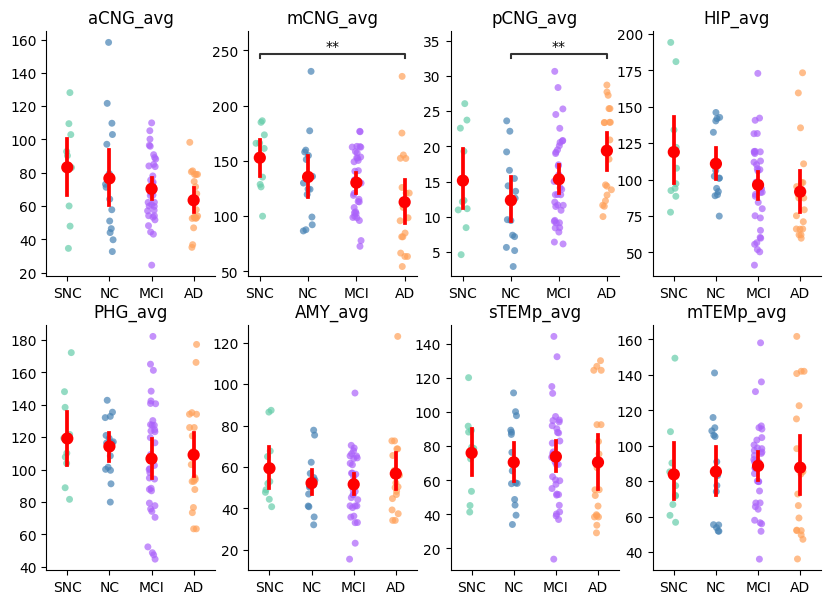

In [6]:
from statannotations.Annotator import Annotator
df = pd.read_csv("./assymetry_wdc.csv")
group = ['SNC', 'NC', 'MCI', 'AD']
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]

df = pd.read_csv("./assymetry_wdc.csv")

for ind in range(0,16,2):
    # mc_individual[f"{key[:-2]}_diff"] = np.abs(mc_individual.iloc[:,ind+2] - mc_individual.iloc[:,ind+3]) / (mc_individual.iloc[:,ind+2] + mc_individual.iloc[:,ind+3])
    print(df.columns[ind+2:ind+4])
    df[f"{df.columns[ind+2][:-2]}_avg"] = np.mean(df.iloc[:,ind+2:ind+4], axis=1)


figure = plt.figure(figsize=(10,7))
for ind, key in enumerate(df.columns[18:]):
    ax = figure.add_subplot(2,4,ind+1)
    ax.set_title(key)
    # sns.violinplot(x="group", y="average", data=mc_individual, cut=0)
    sns.stripplot(x="group", y=key,data=df, palette=colors, label=None, alpha=0.7, ax=ax, zorder=0)
    sns.pointplot(x="group", y=key,data=df, markers="o", color="red", errorbar=None, linestyles="None",ax=ax, zorder=10)
    annot = Annotator(ax, [
                (("SNC"), ("NC")),(("SNC"), ("MCI")), (("SNC"), ("AD")), (("NC"), ("MCI")),(("NC"),("AD")), (("MCI"),("AD"))],
                x="group",
                y=key,
                data = df)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, comparisons_correction='BH')
    annot.apply_and_annotate()
    sns.despine(top=True, right=True)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_group_homo = pd.read_excel('/Users/yilewang/workspaces/data4project/sc_homo_hetero.xlsx', sheet_name='homo_group')
sc_group_hetero = pd.read_excel('/Users/yilewang/workspaces/data4project/sc_homo_hetero.xlsx', sheet_name='hetero_group')

def vplot(x,y,data,ax, title=None, order=None):
    sns.stripplot(x=x,y=y,data=data, order=groups, ax=ax, palette=colors, zorder=0)
    # sns.pointplot(x=x,y=y,data=data, color='red', linestyles="", order=groups, ax=ax, zorder=10)
    ax.set_title(title)
    annot = Annotator(ax, [
                    (("SNC"), ("NC")),(("SNC"), ("MCI")), (("SNC"), ("AD")), (("NC"), ("MCI")),(("NC"),("AD")), (("MCI"),("AD"))],
                    x=x,
                    y=y,
                    data = data)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, comparisons_correction='BH')
    annot.apply_and_annotate()
    sns.despine(top=True, right=True)
    ax.set_ylabel('SC weights')
    ax.set_xlabel('')



figure = plt.figure(figsize=(5,3))
ax1= figure.add_subplot(121)
vplot('group','values',sc_group_homo,ax1, title='Homotopic')
ax2 = figure.add_subplot(122)
vplot('group','values',sc_group_hetero,ax2, title='Heterotopic')